Genre nonfiction has correlation rating-faces: [1.         0.69524068]


AttributeError: 'AxesSubplot' object has no attribute 'show'

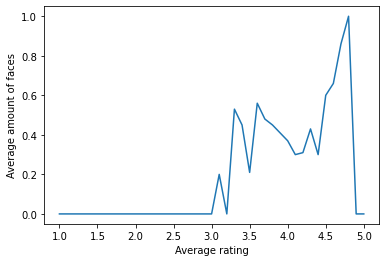

In [27]:

from tools.DatabaseTools import *
import pandas as pd
import seaborn as sns
import numpy as np

"""
Split data in genres
Generate pairplot of each split with another attribute.
"""

def calculateAveragesForStep(feature, feature_at, feature_equal, step_size=0.1):
    """
    Return a dict with the average of the feature per rating step.
    1.0: 43,
    1.1: 23,
    1.2: 11,
    etc
    """
    ranges = []  # the raw classes: 1.1, 2.2 etc
    results = {}  # the sum and counts to calculate average

    for x in np.arange(1.0, 5 + step_size, step_size):  # 1.1, 1.2, 1.3 etc
        label = round(x, 2)
        ranges.append(label)
        # initialize empty results for each color
        results[f"{label}_{feature}_sum"] = 0
        results[f"{label}_{feature}_count"] = 0

    # print(f"Working with empty result: {results}")
    # print(f"Raw classes: {ranges}")

    # iterate book database, for each book retrieve the feature, and append those values to the corresponding
    # rating in the result dict
    set_table("full_parse_results")
    # print("Start parsing.")
    for book_dict in get_all_cursor():
        # skip if feature does not exist
        if feature not in book_dict:
            continue
        if feature_at not in book_dict:
            continue

        # skip if its not a record we want to account
        if book_dict[feature_at] != feature_equal:
            continue

        # retrieve the rating of this book and convert it to the value in the result dict
        rating = str(round(float(book_dict["average_rating"]), 1))

        # skip if label does not exist in result dict: for example 0.0
        if float(rating) not in ranges:
            continue

        # save the sum and amount of times added to sum, to later calculate average
        results[f"{rating}_{feature}_sum"] += float(book_dict[feature])
        results[f"{rating}_{feature}_count"] += 1

    # for each rating, calculate the average and put in result dict
    result = {}
    for x in np.arange(1.0, 5 + step_size, step_size):
        label = round(x, 2)
        sum = results[f"{label}_{feature}_sum"]
        count = results[f"{label}_{feature}_count"]
        # print(f"{label} sum={sum}, count={count}")
        result[label] = 0 if count == 0 else round(sum / count, 2)
    return result

# get 10 genres, and put them in a list from sorted from frequent to less frequent
genre_amount = 10
df = pd.DataFrame(cursor_to_list(get_all_cursor()))
df["average_rating"] = pd.to_numeric(df["average_rating"]) # convert  to numeric to have value counts work
genres = df["genre_0"].value_counts()[:genre_amount].index.tolist()

step_size = 0.1
for genre in genres:
    averages = calculateAveragesForStep("amount_of_faces", "genre_0", genre, step_size)
    x = [float(key) for key in averages.keys()]
    y = [float(value) for value in averages.values()]
    corr = np.corrcoef(x, y)
    print(f"Genre {genre} has correlation rating-faces: {corr[0]}")
    plot = sns.lineplot(x=x, y=y)
    plot.set(xlabel="Average rating", ylabel="Average amount of faces")
    plot.show()


# plot.set(ylim=(0, 1.25))
# plot.set(xlim=(2.7, 5.0))
plot.set(xlabel="Average rating", ylabel="Average amount of faces")
plot.get_figure().savefig(f"../plots/genreplot_{step_size}.svg", format="svg", dpi=1200)